# Spherical coordinates simulations to generate proportions 

The proportions of our three materials, clay, sand and intermediate sum to one: $p_{clay} + p_{sand}+p_{inte} = 1$. In this three dimensional space, due to the summing constraint, there are only two degrees of freedom.

Let us denote $x^2 = p_{clay}=$, $y^2=p_{sand}$ and $z^2=p_{inte}$, we now have the equation of the unit sphere: $x^2 + y^2+z^2 = 1$.

Now we can get the spherical coordinates $(\Theta, \phi)$ corresponding to the cartesian coordinates (x,y,z):
 - $\Theta = arccos(\frac{z}{r})$, with $r=\sqrt{x^2 + y^2+z^2}$
 - $\phi = sign(y) \times arccos(\frac{x}{\sqrt{x^2 + y^2}})$
 
Note that we can now work in a lower dimensional space (2 vs 3) due to the transformation. Because proportions are bounded in $[0,1]$, $\Theta$ and $\phi$ are bounded in $[0,\frac{\pi}{2}]$.

$\Theta$ and $\phi$ simulations are transformed back to proportions, as:
 - $x = r \times sin\Theta \times cos\phi$
 - $y = r \times sin\Theta \times sin\phi$
 - $z = r \times cos\Theta $

### Load modules and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
sys.path.append("../src/")

from lbd_functions import printtimelogwithstarline,printtimelog
from utils import get_ecdf_area_difference, get_ecdf, interpolate_ecdf, interp_ecdf_normalize_x
from utils import get_spherical_coordinate_from_proportions, get_proportions_from_spherical_coordinates
from utils import get_best_fitting_plane,get_Z_from_plane_coeffs,remove_trend_from_data
import scipy.linalg
import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python

df_summary = pd.read_csv('../data/boreholes-processed/LBW_extended_STRATA_LOG_summary.csv')
df_classified_log_fn = '../data/boreholes-processed/LBW_extended_STRATA_LOG_classified.csv'

def get_df_2D_prop(df_2D_proportions_level_0,level_0_name,df_summary):
    ix_2D_prop = np.asarray(np.where(df_2D_proportions_level_0['level_0']==level_0_name)).flatten()
    df_2D_prop = df_summary[['RN','Easting','Northing']].copy()
    df_2D_prop = df_summary[['RN','Easting','Northing']].join(df_2D_proportions_level_0.loc[ix_2D_prop,['RN','proportion']].set_index('RN'),on='RN',how='outer')
    ixtmp = np.asarray(np.where(df_2D_prop['proportion'].isnull())).flatten()
    df_2D_prop.loc[ixtmp,'proportion']=0.0
    return df_2D_prop 

def add_nst_cols(df_2D_prop, colname, plot=False):
    # NORMAL SCORE TRANSFORM
    df_2D_prop['tv_'+colname] = np.nan
    df_2D_prop['tns_'+colname] = np.nan
    df_2D_prop['nst_'+colname] = np.nan
    df_2D_prop.loc[:,'nst_'+colname], df_2D_prop.loc[:,'tv_'+colname], df_2D_prop.loc[:,'tns_'+colname] = geostats.nscore(df_2D_prop, colname)
    if plot:
        # check plot
        plt.figure(dpi=100)
        plt.hist(df_2D_prop.loc[:,'nst_'+colname], bins=20)
        plt.title('histrogram of Normal Score Transformed '+colname)
        plt.show()
    return

def get_varmap(df_2D_prop,colname,lag_nb,lag_width):
    vmap, _ = geostats.varmapv(df_2D_prop,'Easting','Northing',colname,tmin=-999,tmax=999,nxlag=lag_nb,nylag=lag_nb,dxlag=lag_width,dylag=lag_width,minnp=1,isill=1)
    nanidx_sand = np.where(vmap==-999)
    vmap[nanidx_sand]=np.nan
    return vmap


In [2]:
df_processed_log = pd.read_csv(df_classified_log_fn)

ix_sediments = np.asarray(np.where(
    (df_processed_log['level_0']!='Basement') & 
    (df_processed_log['level_0']!='Weathered basement')
)).flatten()


### Spherical transform of proportions

In [3]:
# 2D proportions - prop average by drillhole
df_2D_proportions_level_0 = df_processed_log.loc[ix_sediments,['RN','level_0','thickness']].groupby(['RN','level_0'],as_index=False).sum()
df_bh_thickness = df_2D_proportions_level_0.groupby(['RN'],as_index=False).sum() #.rename(columns = {'thickness': 'bh_thickness'})
df_2D_proportions_level_0 = df_2D_proportions_level_0.join(df_bh_thickness.set_index('RN'),on='RN', how='left', lsuffix='',rsuffix='_bh')
df_2D_proportions_level_0['proportion'] = df_2D_proportions_level_0['thickness']/df_2D_proportions_level_0['thickness_bh']

# TO GET ONE ROW PER BOREHOLE, EVEN IF PROPORTION==0
df_2D_prop_clay = get_df_2D_prop(df_2D_proportions_level_0,'Clay',df_summary)
df_2D_prop_sand = get_df_2D_prop(df_2D_proportions_level_0,'Sands',df_summary)
df_2D_prop_inte = get_df_2D_prop(df_2D_proportions_level_0,'Intermediate',df_summary)

df_2D_prop_clay.rename(columns={'proportion': 'prop_clay'},inplace=True)
df_2D_prop_sand.rename(columns={'proportion': 'prop_sand'},inplace=True)
df_2D_prop_inte.rename(columns={'proportion': 'prop_inte'},inplace=True)

df_2D_prop = df_2D_prop_clay.join(df_2D_prop_sand[['RN','prop_sand']].set_index('RN'),on='RN', how='left').join(
    df_2D_prop_inte[['RN','prop_inte']].set_index('RN'),on='RN', how='left')

df_2D_prop['theta'],df_2D_prop['phi'] = get_spherical_coordinate_from_proportions(df_2D_prop['prop_clay'].values,
                                                                                  df_2D_prop['prop_sand'].values,
                                                                                  df_2D_prop['prop_inte'].values)

ix = np.asarray(np.where(df_2D_prop['phi'].isnull() | df_2D_prop['theta'].isnull())).flatten()
#df_2D_prop.iloc[ix,:]
df_2D_prop.drop(ix,inplace=True)
df_2D_prop.reset_index(drop=True,inplace=True)


C:\Users\00102908\my-UWA\LowerBurdekinDelta\notebooks\../src\utils.py:176: RuntimeWarning: invalid value encountered in divide
  x = np.sqrt(p1/psum)
C:\Users\00102908\my-UWA\LowerBurdekinDelta\notebooks\../src\utils.py:177: RuntimeWarning: invalid value encountered in divide
  y = np.sqrt(p2/psum)
C:\Users\00102908\my-UWA\LowerBurdekinDelta\notebooks\../src\utils.py:178: RuntimeWarning: invalid value encountered in divide
  z = np.sqrt(p3/psum)


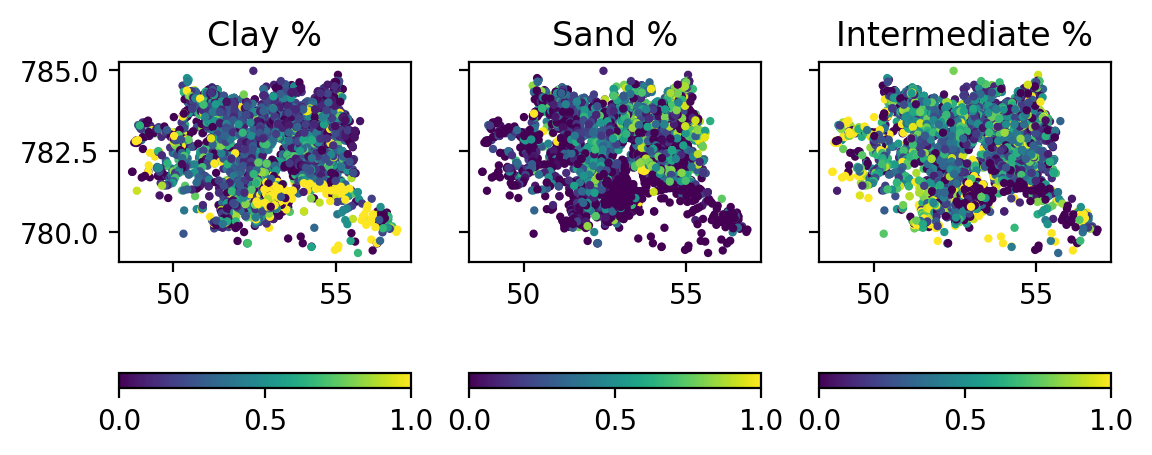

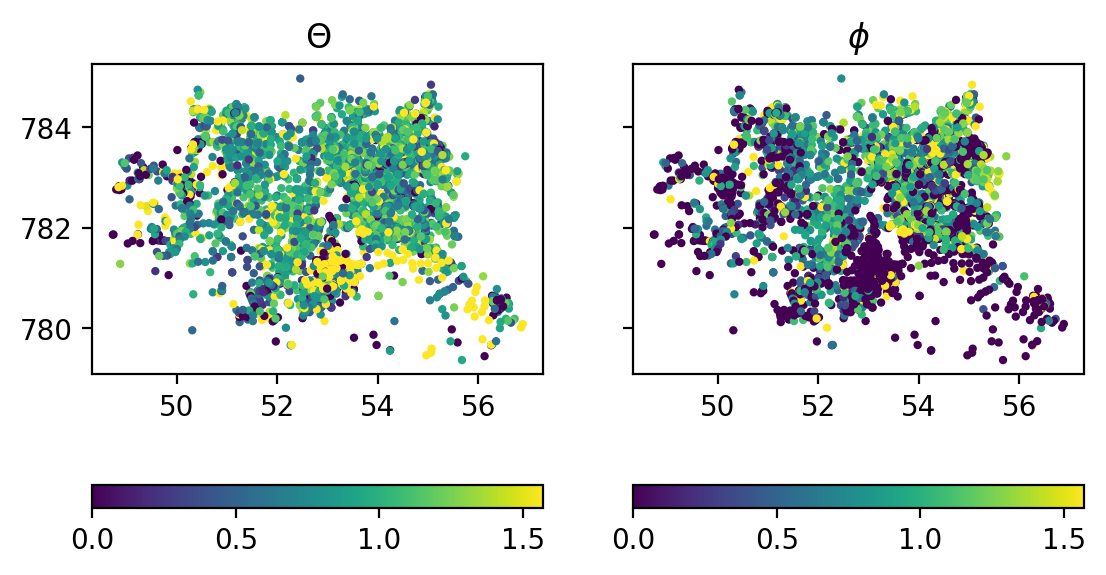

In [4]:
s=4

fig,ax = plt.subplots(1,3,dpi=200,sharey=True)
ax[0].set_title('Clay %')
im0=ax[0].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['prop_clay'].values,
                  cmap='viridis',s=s)
ax[0].set_aspect(1)
fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('Sand %')
im1=ax[1].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['prop_sand'].values,
                  cmap='viridis',s=s)
ax[1].set_aspect(1)
fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

ax[2].set_title('Intermediate %')
im2=ax[2].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['prop_inte'].values,
                  cmap='viridis',s=s)
ax[2].set_aspect(1)
fig.colorbar(im2,ax=ax[2],orientation='horizontal', fraction=.035)

plt.show()


fig,ax = plt.subplots(1,2,dpi=200,sharey=True)
ax[0].set_title('$\Theta$')
im0=ax[0].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['theta'].values,
                  cmap='viridis',s=s)
ax[0].set_aspect(1)
fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('$\phi$')
im1=ax[1].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['phi'].values,
                  cmap='viridis',s=s)
ax[1].set_aspect(1)
fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

plt.show()

In [5]:
# global_theta,global_phi = get_spherical_coordinate_from_proportions(df_stats_level_0.loc['Clay','proportion'],
#                                                                     df_stats_level_0.loc['Sands','proportion'],
#                                                                     df_stats_level_0.loc['Intermediate','proportion'],
#                                                                    verb=True)

# s=4
# fig,ax = plt.subplots(1,2,dpi=200,sharey=True)
# ax[0].set_title('$\Theta$ deviation')
# im0=ax[0].scatter(df_2D_prop['Easting'].values/1E4,
#                   df_2D_prop['Northing'].values/1E4,
#                   c = df_2D_prop['theta'].values - global_theta,
#                   cmap='viridis',s=s)
# ax[0].set_aspect(1)
# fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

# ax[1].set_title('$\phi$ deviation')
# im1=ax[1].scatter(df_2D_prop['Easting'].values/1E4,
#                   df_2D_prop['Northing'].values/1E4,
#                   c = df_2D_prop['phi'].values - global_phi,
#                   cmap='viridis',s=s)
# ax[1].set_aspect(1)
# fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

# plt.show()

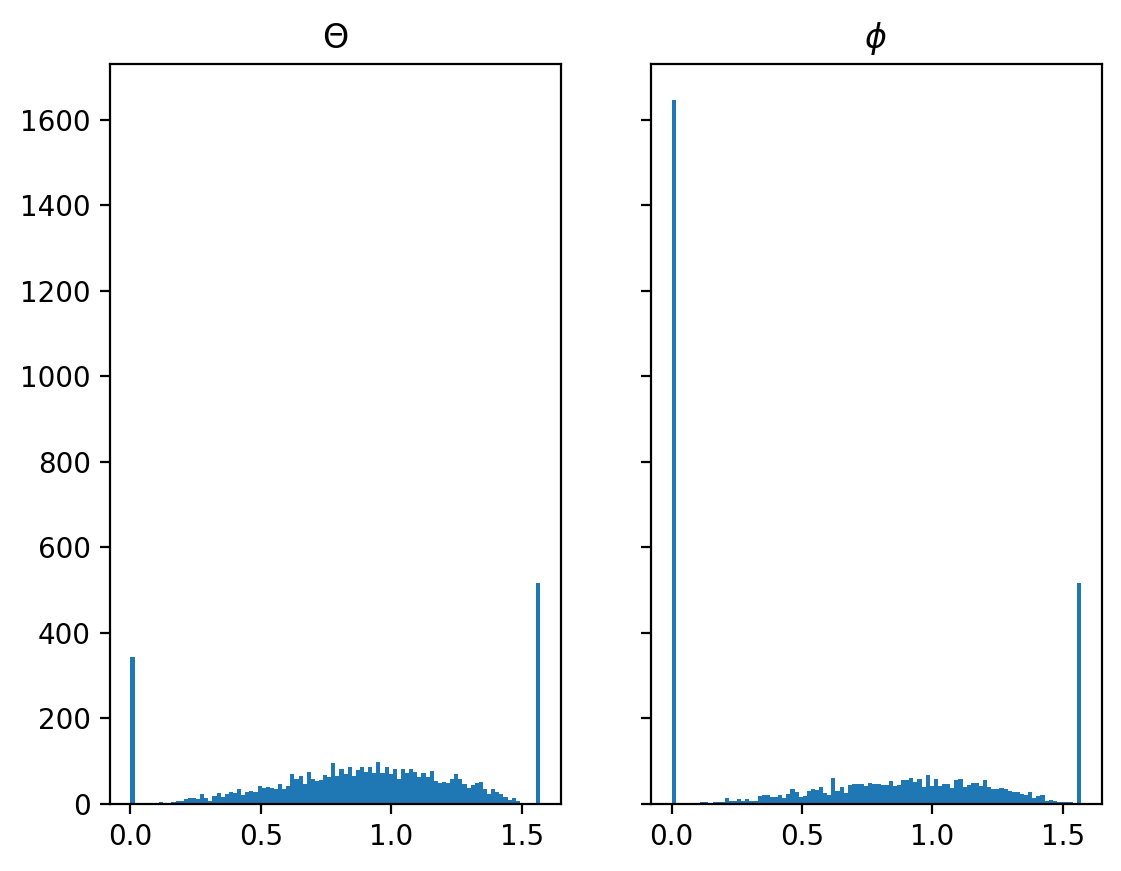

In [6]:
nbins=100
fig,ax = plt.subplots(1,2,dpi=200,sharey=True)
ax[0].set_title('$\Theta$')
ax[0].hist(df_2D_prop['theta'].values,nbins)
ax[1].set_title('$\phi$ ')
ax[1].hist(df_2D_prop['phi'].values,nbins)
plt.show()

### Semi-variogram analysis

In [7]:
# FIND PLANAR TREND
xmin = 52.5*1E4
xmax = 56*1E4
ymin= 781*1E4
ymax = 785*1E4

dx = dy = 250
nx = np.round((xmax-xmin)/dx).astype(int)
ny = np.round((ymax-ymin)/dy).astype(int)

xvec = np.linspace(xmin+dx/2,xmax-dx/2,num=nx,endpoint=True)
yvec = np.linspace(ymin+dy/2,ymax-dy/2,num=ny,endpoint=True)
X,Y = np.meshgrid(xvec,yvec)

plane_coeffs_theta = get_best_fitting_plane(df_2D_prop,'theta')
trend_theta = get_Z_from_plane_coeffs(X,Y,plane_coeffs_theta)
df_2D_prop['theta_dtd'] = remove_trend_from_data(df_2D_prop,'theta',plane_coeffs_theta)

plane_coeffs_phi = get_best_fitting_plane(df_2D_prop,'phi')
trend_phi = get_Z_from_plane_coeffs(X,Y,plane_coeffs_phi)
df_2D_prop['phi_dtd'] = remove_trend_from_data(df_2D_prop,'phi',plane_coeffs_phi)


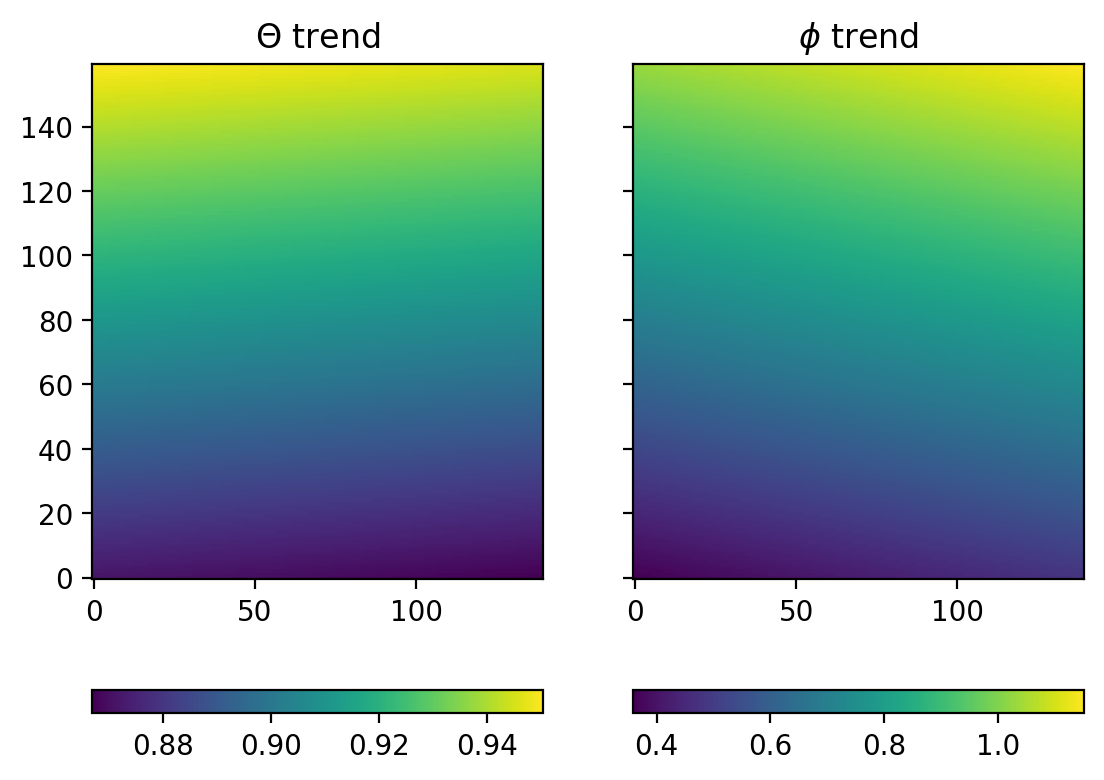

In [8]:
# PLOT PLANAR TREND
fig,ax = plt.subplots(1,2,dpi=200,sharey=True)
ax[0].set_title('$\Theta$ trend')
im0=ax[0].imshow(trend_theta, origin='lower', cmap='viridis')
fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('$\phi$ trend')
im1=ax[1].imshow(trend_phi, origin='lower', cmap='viridis')
fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

plt.show()

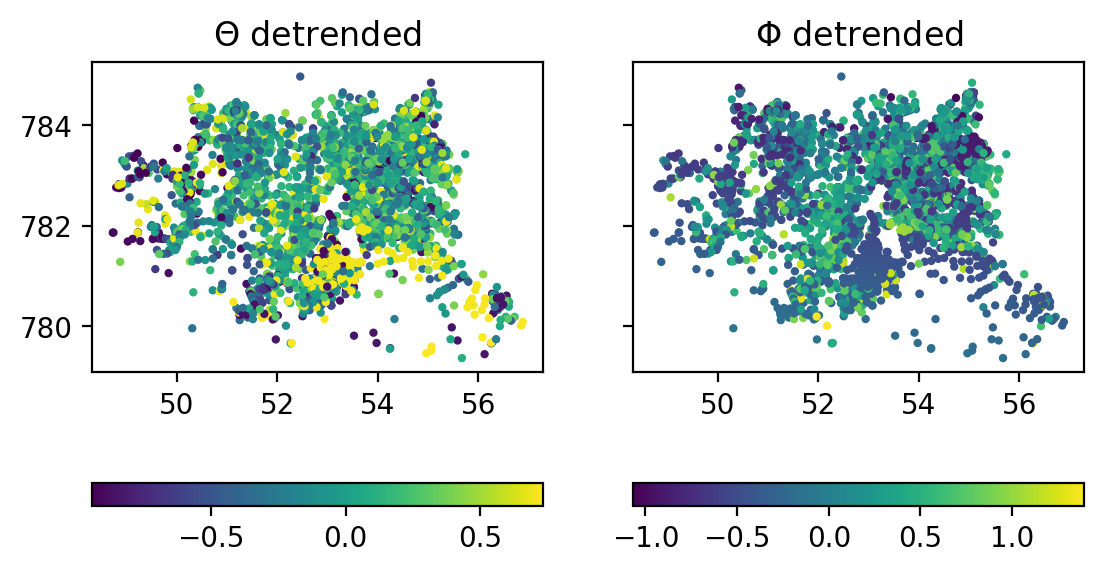

In [9]:
# PLOT DETRENDED DATA
s=4
fig,ax = plt.subplots(1,2,dpi=200,sharey=True)
ax[0].set_title('$\Theta$ detrended')
im0=ax[0].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['theta_dtd'].values,
                  cmap='viridis',s=s)
ax[0].set_aspect(1)
fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('$\Phi$ detrended')
im1=ax[1].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['phi_dtd'].values,
                  cmap='viridis',s=s)
ax[1].set_aspect(1)
fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

plt.show()

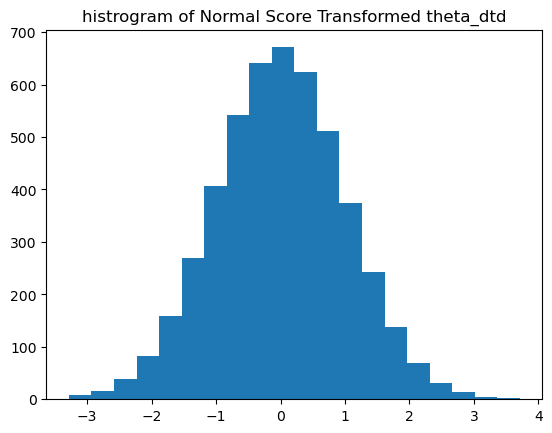

In [10]:
# NORMAL SCORE TRANSFORM
add_nst_cols(df_2D_prop,'theta_dtd',plot=True)
add_nst_cols(df_2D_prop,'phi_dtd')

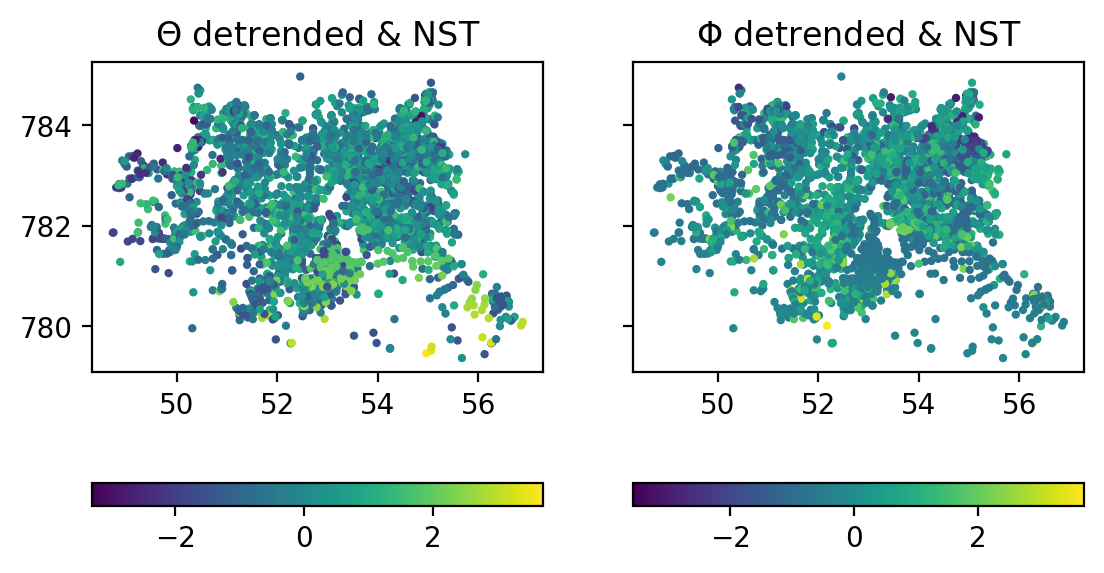

In [11]:
# PLOT DETRENDED DATA
s=4
fig,ax = plt.subplots(1,2,dpi=200,sharey=True)
ax[0].set_title('$\Theta$ detrended & NST')
im0=ax[0].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['nst_theta_dtd'].values,
                  cmap='viridis',s=s)
ax[0].set_aspect(1)
fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('$\Phi$ detrended & NST')
im1=ax[1].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['nst_phi_dtd'].values,
                  cmap='viridis',s=s)
ax[1].set_aspect(1)
fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

plt.show()

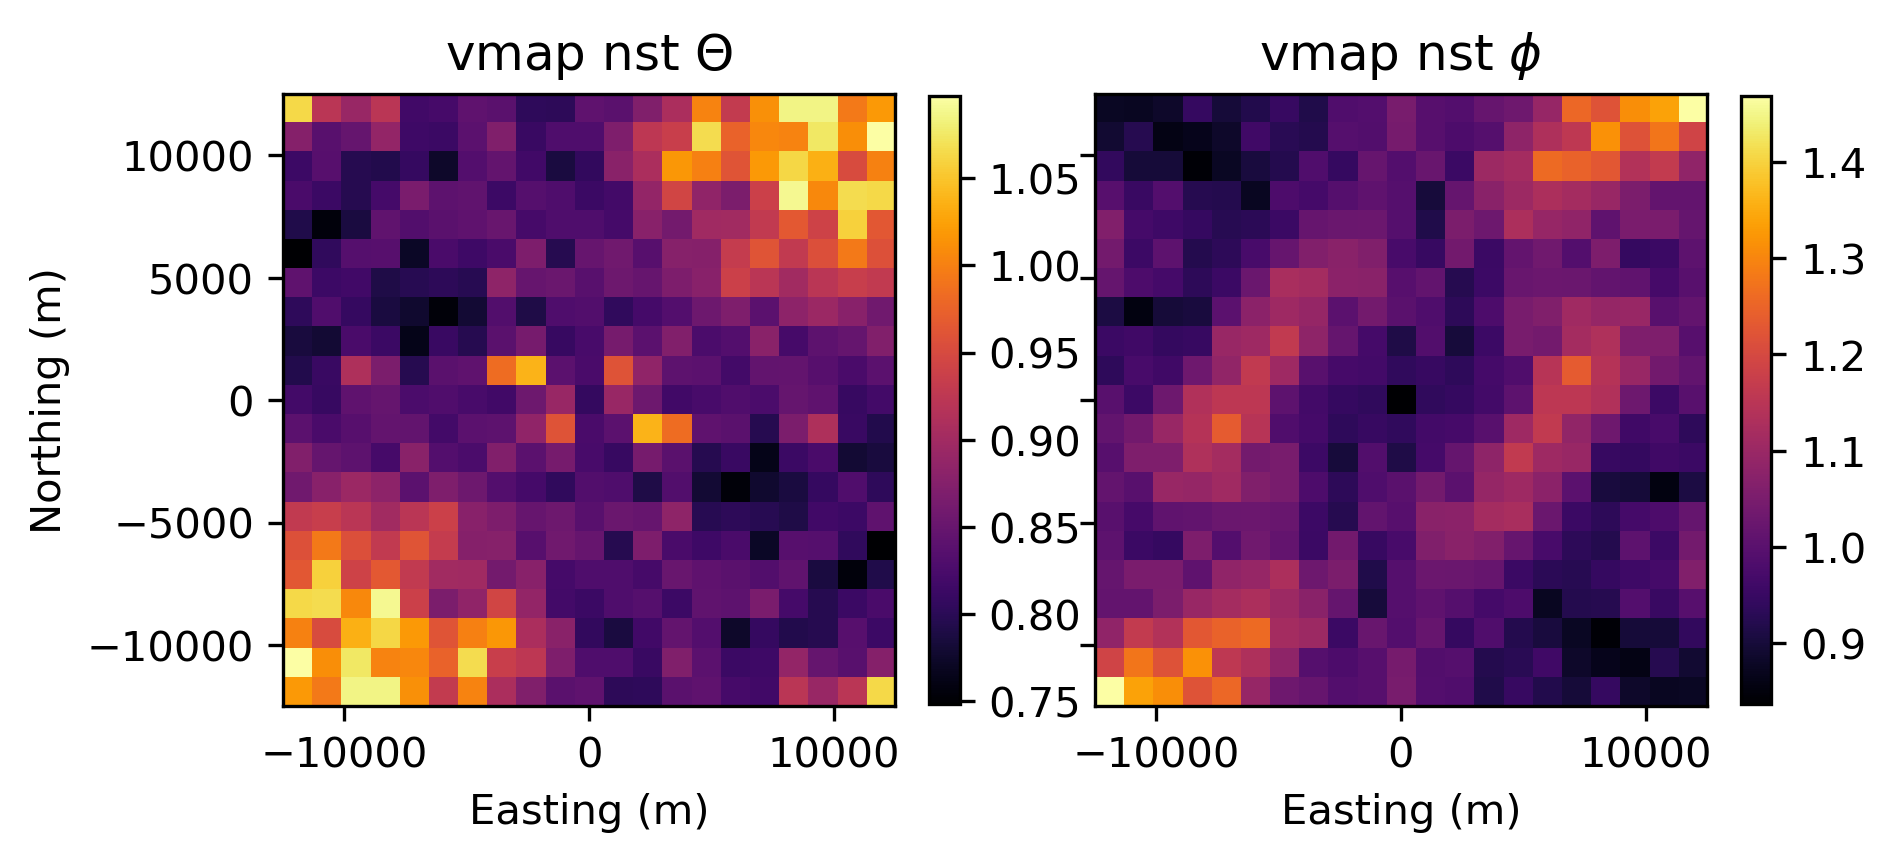

In [12]:
# Semi-variogram analysis

#%% Variogram maps of detrended and normal score transformed data
lag_nb = 10
dmax = ((xmax-xmin)+(ymax-ymin))/6
lag_width = dmax/lag_nb


vmap_theta = get_varmap(df_2D_prop,'nst_theta_dtd',lag_nb,lag_width)
vmap_phi = get_varmap(df_2D_prop,'nst_phi_dtd',lag_nb,lag_width)

# PLOT VARIOGRAM MAPS
leftextent = -lag_width*lag_nb
rightextent = lag_width*lag_nb
bottomextent = -lag_width*lag_nb
topextent = lag_width*lag_nb
extent = (leftextent,rightextent,bottomextent,topextent)

fig,ax = plt.subplots(1,2,dpi=300,sharey=True)
im0 = ax[0].imshow(vmap_theta,extent=extent,cmap='inferno')
ax[0].set_title('vmap nst $\Theta$')
ax[0].set_xlabel('Easting (m)')
ax[0].set_ylabel('Northing (m)')
fig.colorbar(im0,ax=ax[0],orientation='vertical', fraction=.045)

im1 = ax[1].imshow(vmap_phi,extent=extent,cmap='inferno')
ax[1].set_title('vmap nst $\phi$')
ax[1].set_xlabel('Easting (m)')
fig.colorbar(im1,ax=ax[1],orientation='vertical', fraction=.045)
plt.show()


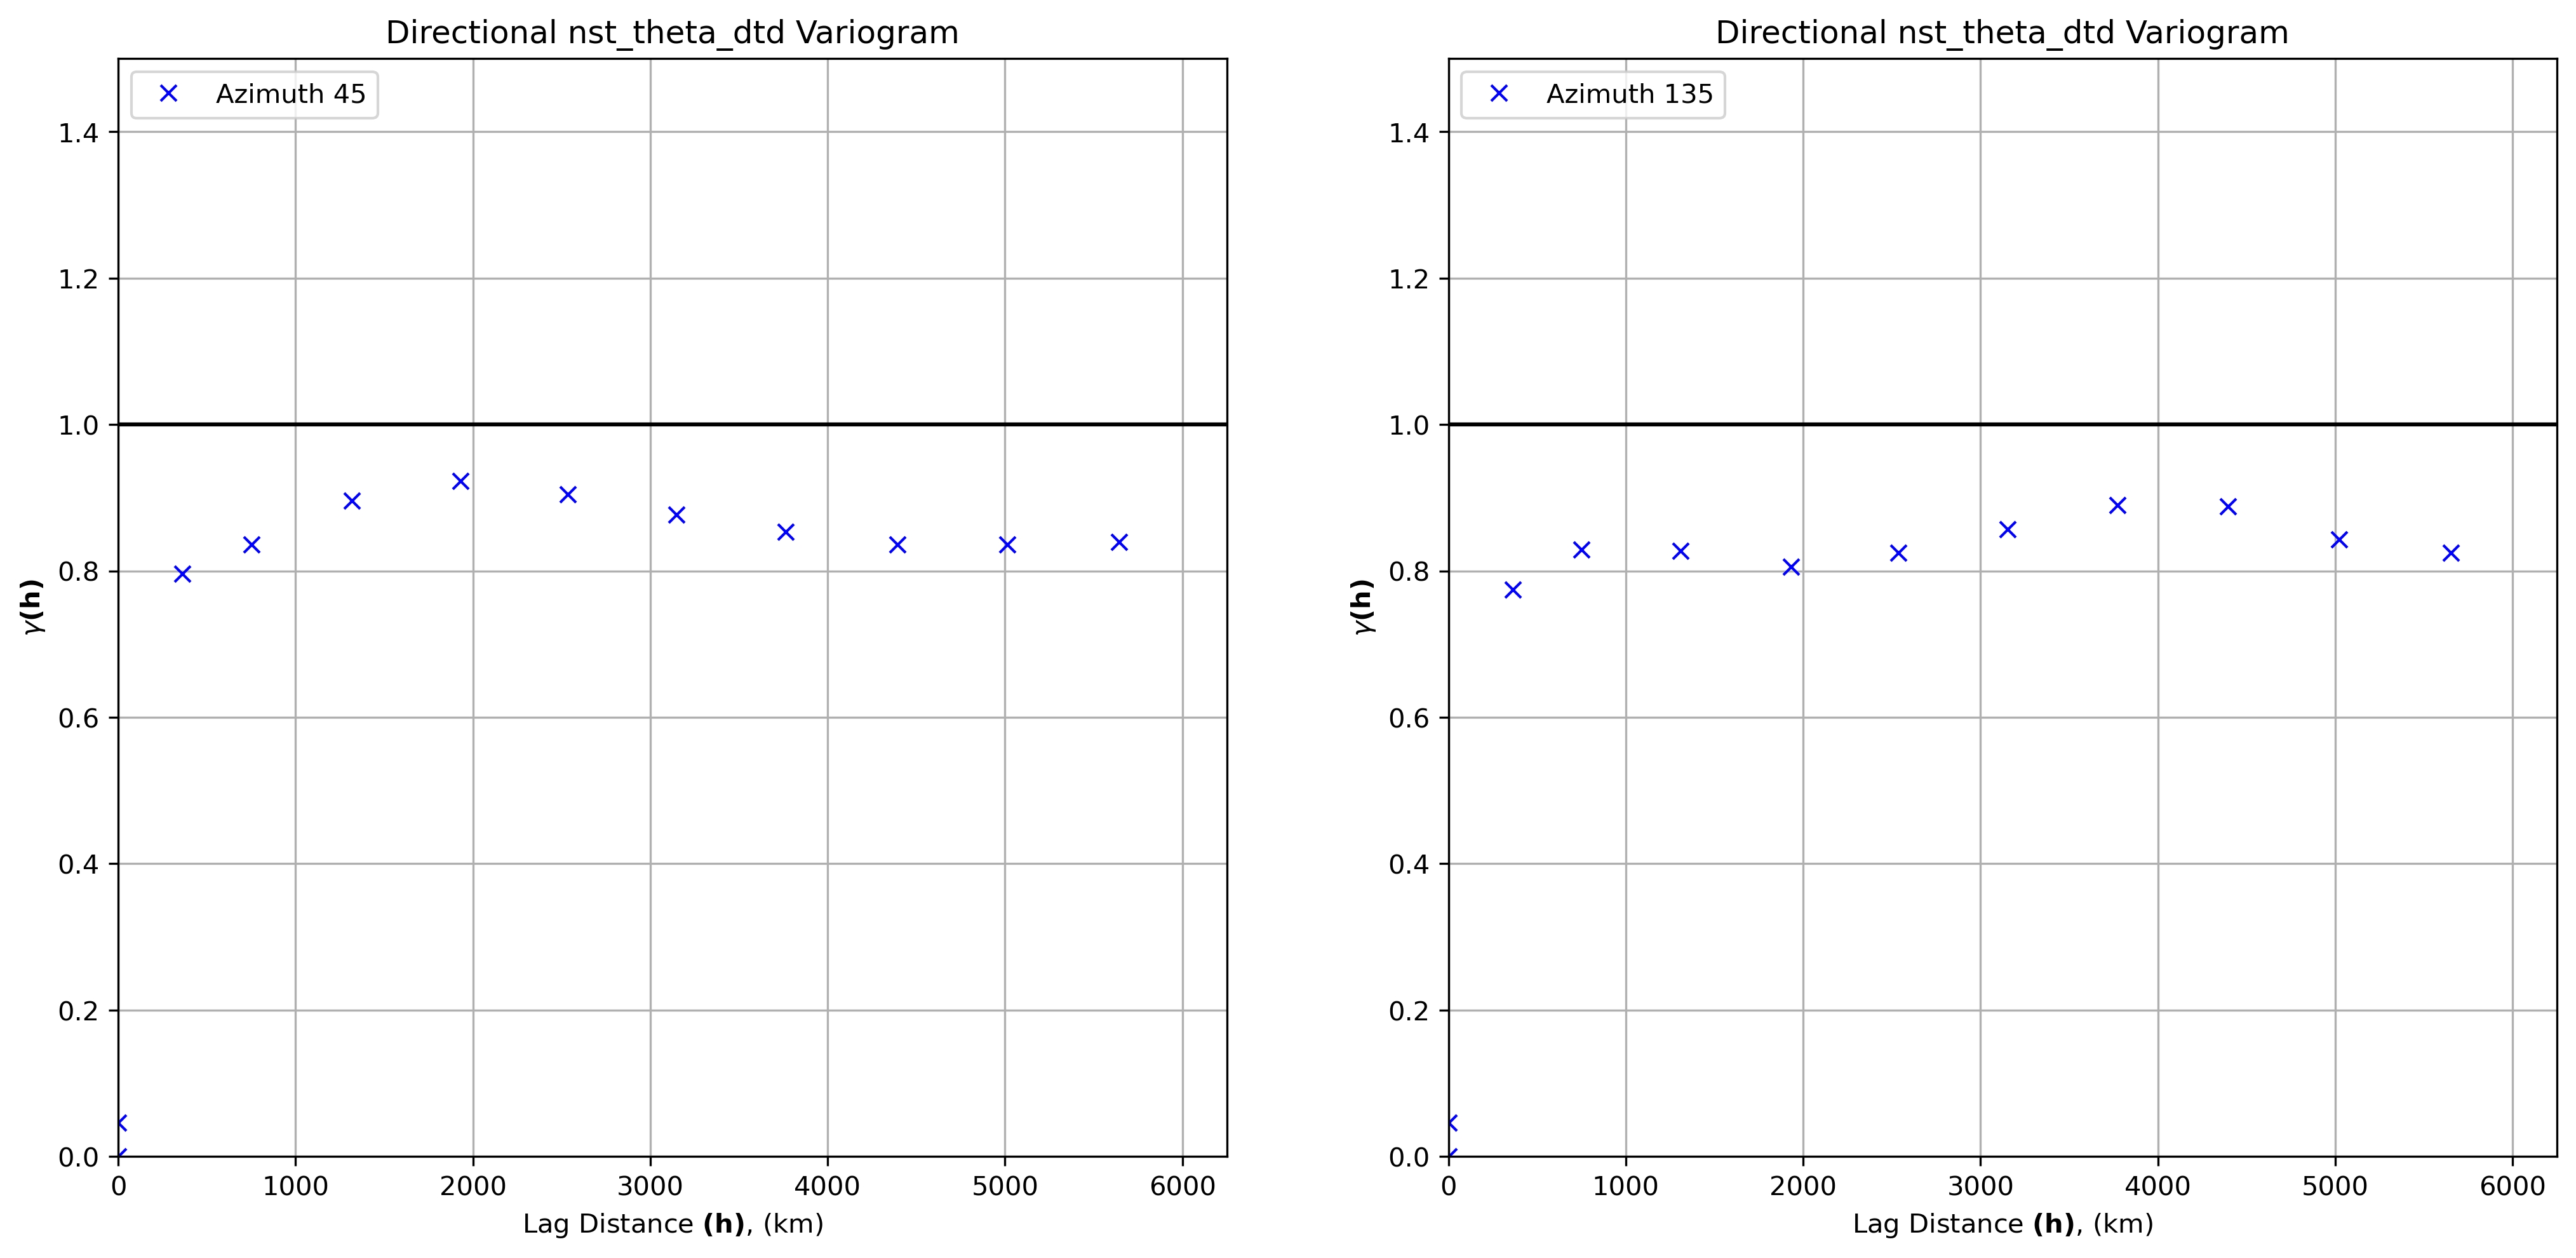

In [13]:
#%% ANISOTROPIC EXPERIMENTAL VARIOGRAM
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = lag_width/2; lag_tol = lag_dist; nlag = lag_nb;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 45                            # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [45,135]           # directions in azimuth to consider

# Arrays to store the results
lag_theta = np.zeros((len(azi_mat),nlag+2)); 
gamma_theta = np.zeros((len(azi_mat),nlag+2)); 
npp_theta = np.zeros((len(azi_mat),nlag+2));

plt.figure(dpi=300)
for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag_theta[iazi,:], gamma_theta[iazi,:], npp_theta[iazi,:] = geostats.gamv(df_2D_prop,'Easting','Northing','nst_theta_dtd',tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(1,2,iazi+1)
    plt.plot(lag_theta[iazi,:],gamma_theta[iazi,:],'x',color = 'blue',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,lag_dist*nlag],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (km)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional nst_theta_dtd Variogram')
    plt.xlim([0,lag_dist*nlag])
    plt.ylim([0,1.5])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()


 x,y,z offsets = 35.355339027597786,35.35533909105696
 x,y,z offsets = 35.35533915451614,-35.35533896413862


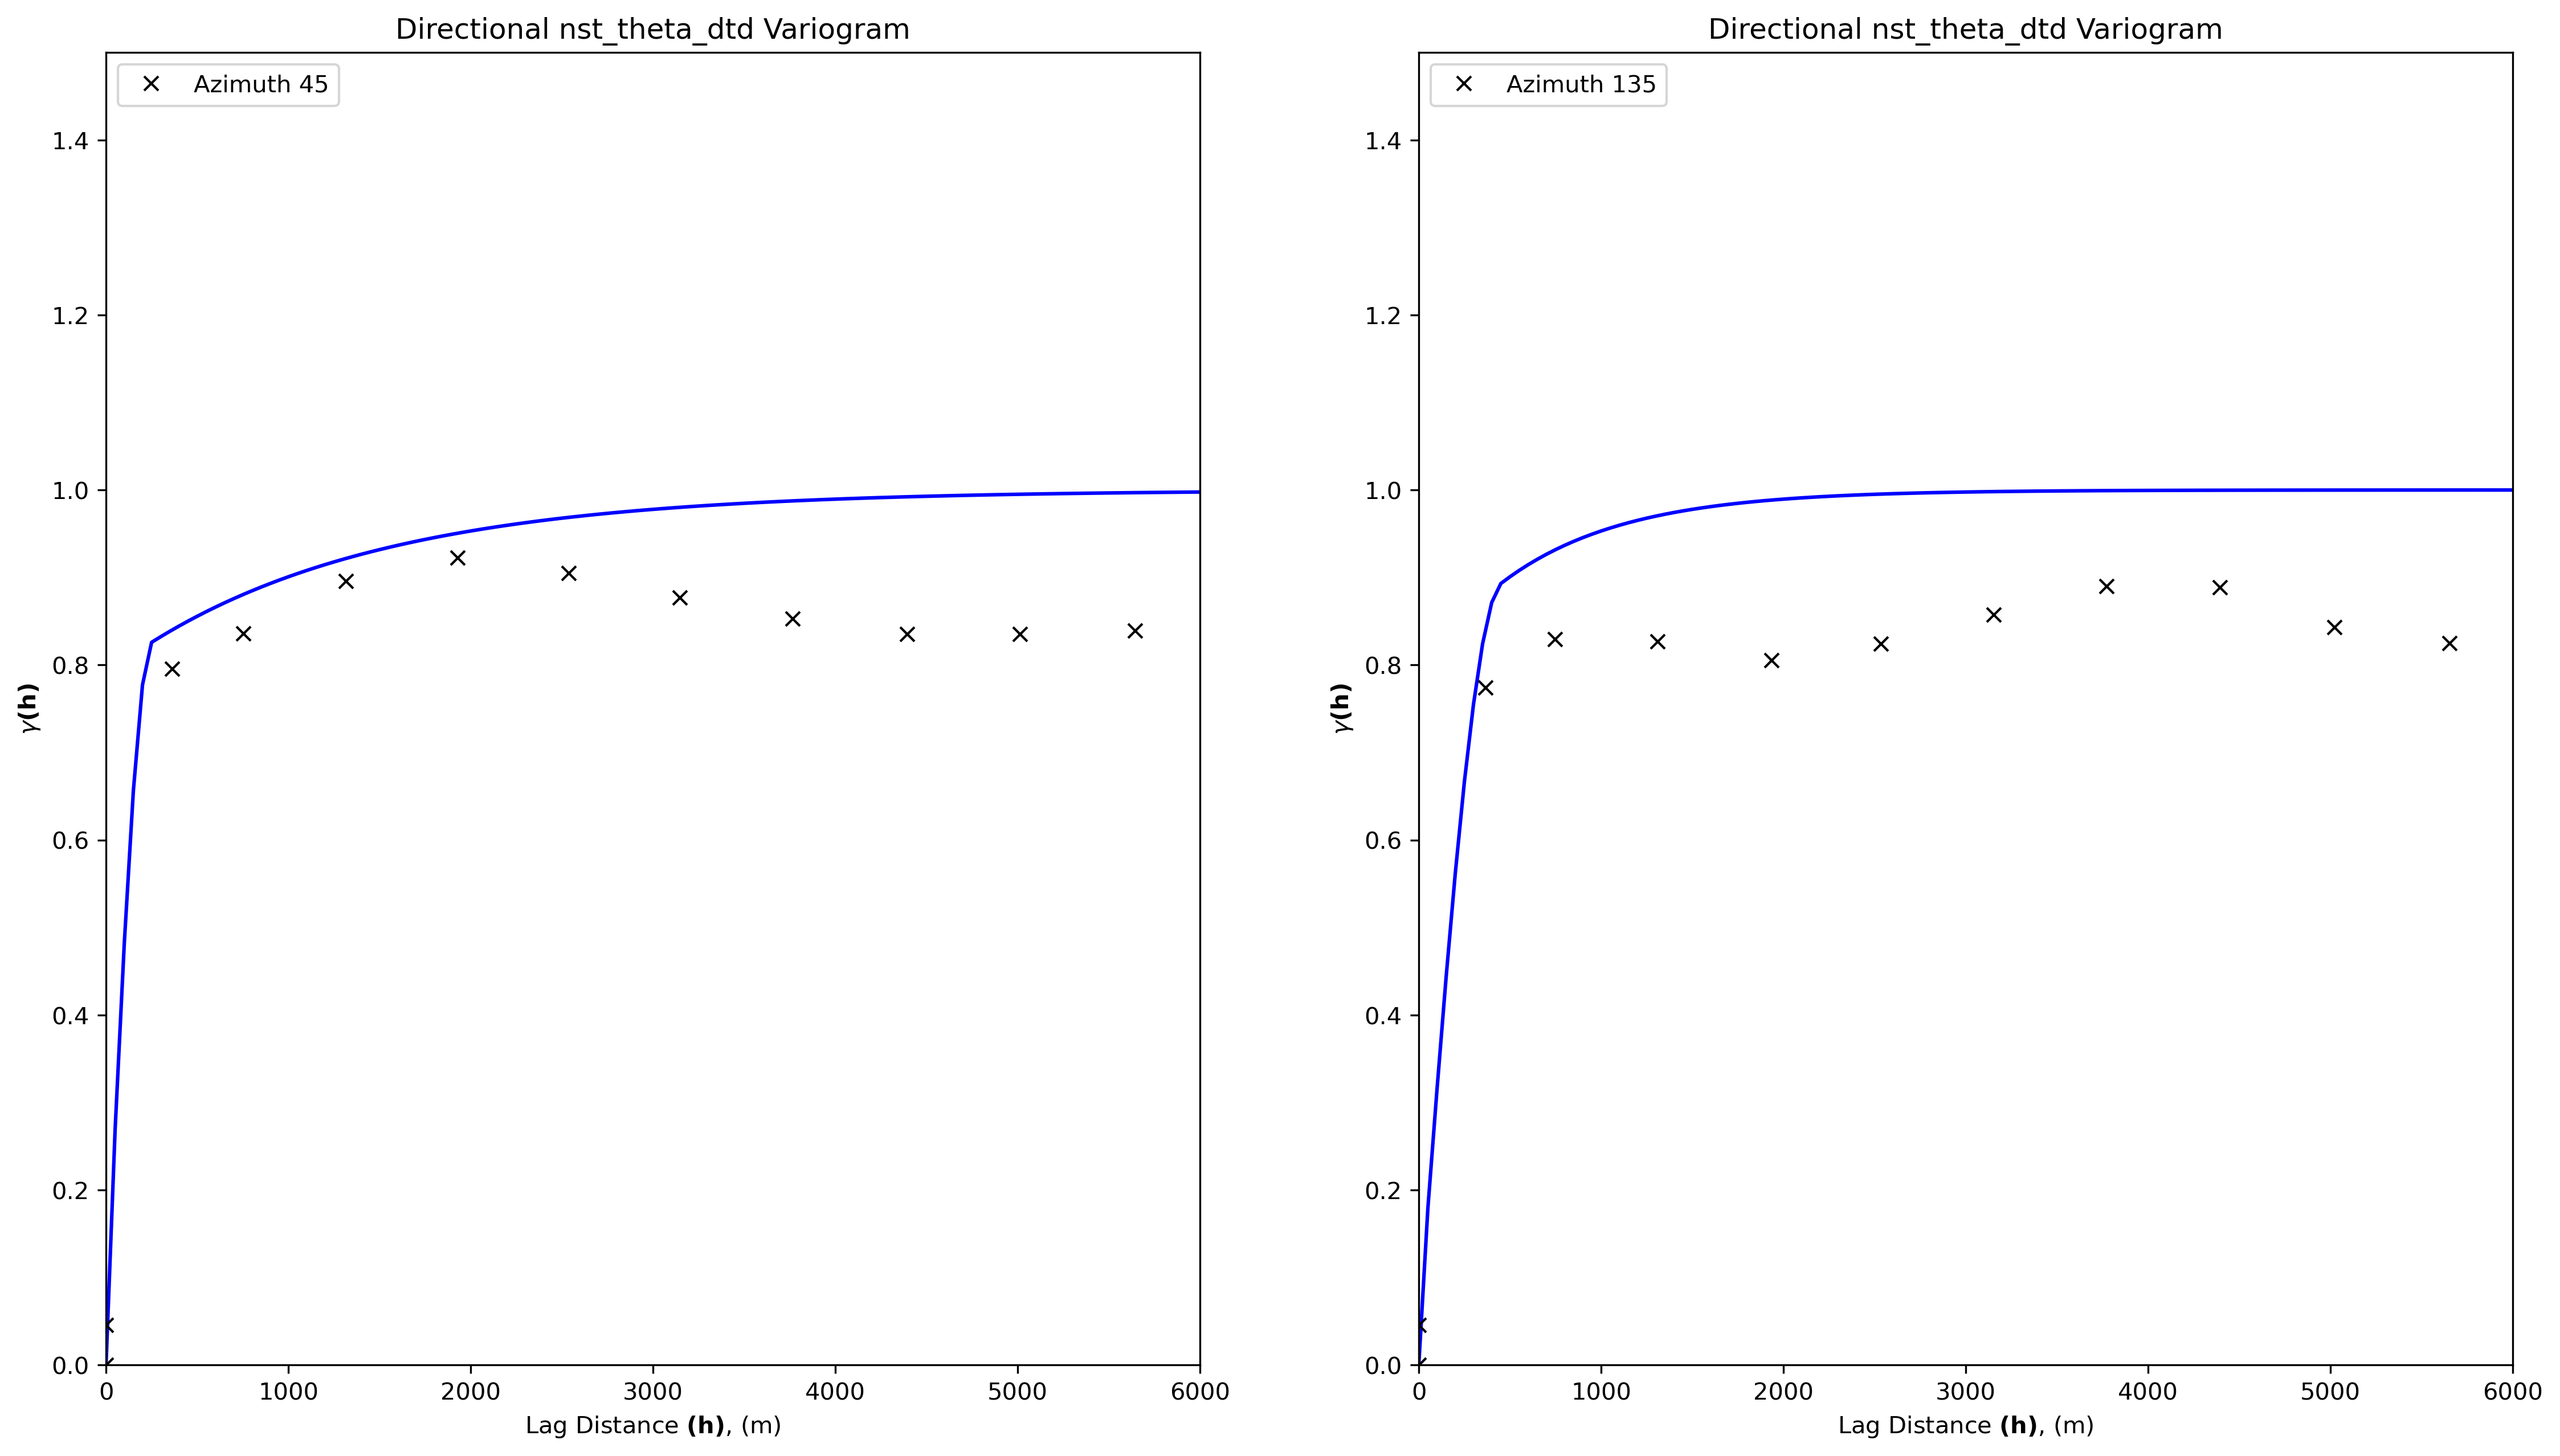

In [14]:
#%% ANISTOROPIC VARIOGRAM FITTING
nug = 0.04; nst = 2                                             # 2 nest structure variogram model parameters
it1 = 1; cc1 = 0.75; azi1 = 135; hmaj1 = 450; hmin1 = 250
it2 = 2; cc2 = 0.21; azi2 = 45; hmaj2 = 4000; hmin2 = 2000

vario_theta = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2) # make model object )#
xlag = 100/2; nlag = 120; 
azm = 45;                                # project the model in the 045 azimuth
index45,h45,gam45,cov45,ro45 = geostats.vmodel(nlag,xlag,azm,vario_theta)
azm = 135                                                      # project the model in the 135 azimuth
index135,h135,gam135,cov135,ro135 = geostats.vmodel(nlag,xlag,azm,vario_theta)

plt.figure(dpi=300)
plt.subplot(1,2,1)
# plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h45,gam45,color = 'blue')
plt.plot(lag_theta[0,:],gamma_theta[0,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[0]))
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional nst_theta_dtd Variogram')
plt.xlim([0,xlag*nlag])
plt.ylim([0,1.5])
plt.legend(loc='upper left')

plt.subplot(1,2,2)
# plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h135,gam135,color = 'blue')
plt.plot(lag_theta[1,:],gamma_theta[1,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[1]))
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional nst_theta_dtd Variogram')
plt.xlim([0,xlag*nlag])
plt.ylim([0,1.5])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

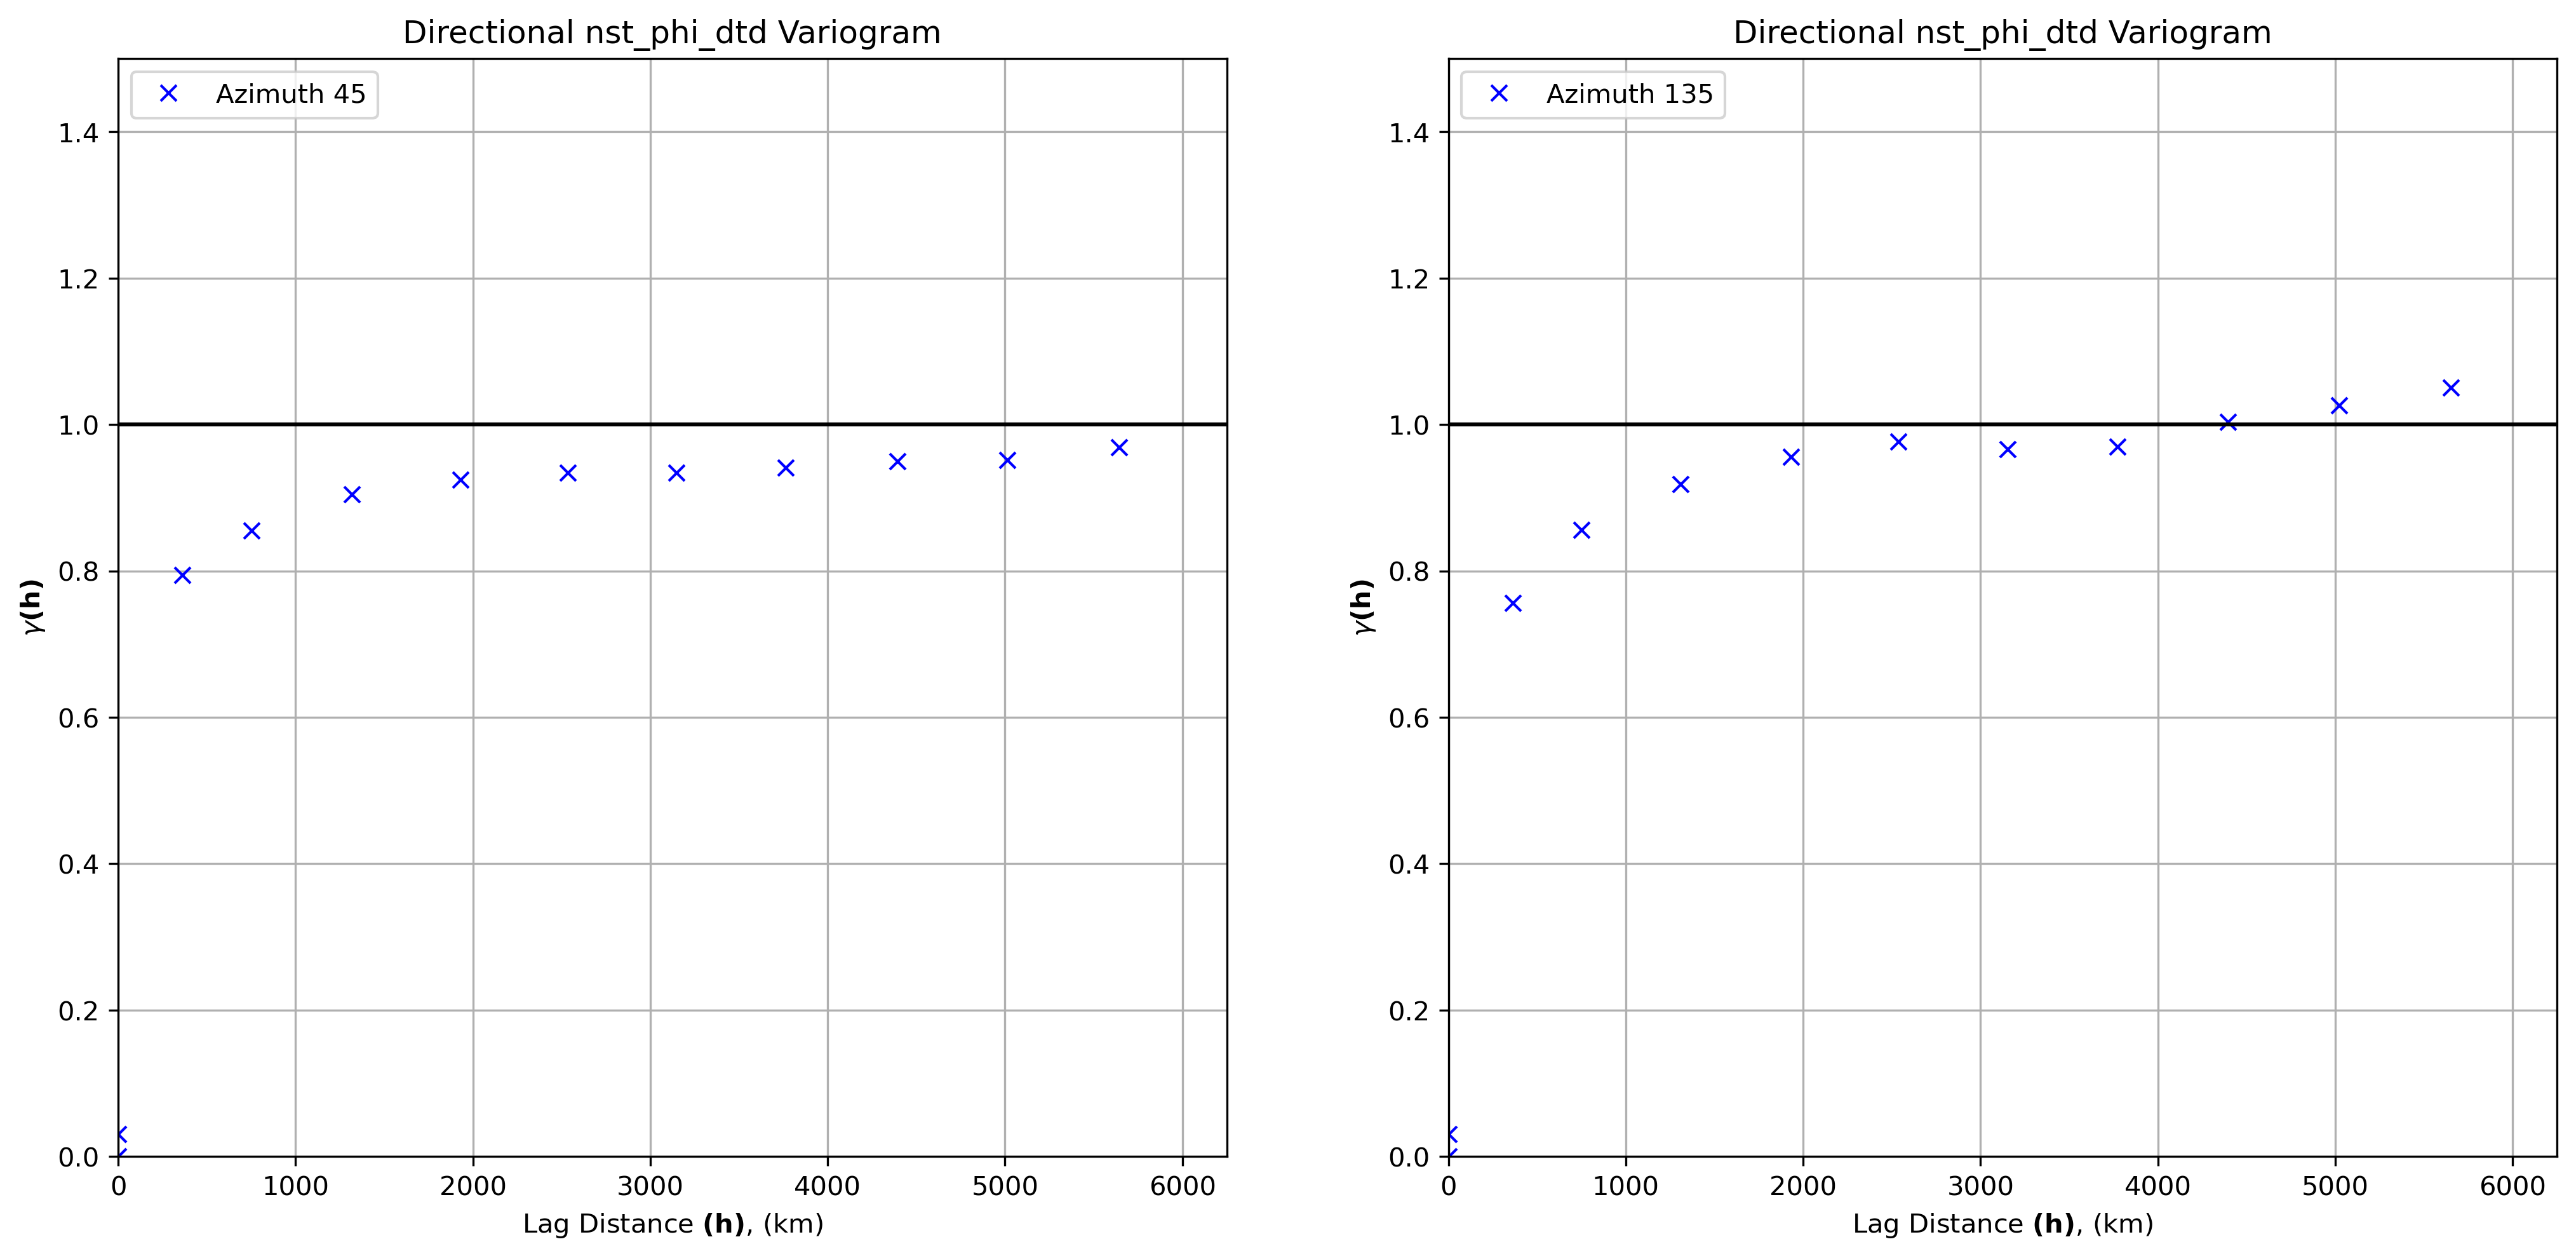

In [15]:
#%% ANISOTROPIC EXPERIMENTAL VARIOGRAM
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = lag_width/2; lag_tol = lag_dist; nlag = lag_nb;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 45                            # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [45,135]           # directions in azimuth to consider

# Arrays to store the results
lag_phi = np.zeros((len(azi_mat),nlag+2)); 
gamma_phi = np.zeros((len(azi_mat),nlag+2)); 
npp_phi = np.zeros((len(azi_mat),nlag+2));

plt.figure(dpi=300)
for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag_phi[iazi,:], gamma_phi[iazi,:], npp_phi[iazi,:] = geostats.gamv(df_2D_prop,'Easting','Northing','nst_phi_dtd',tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(1,2,iazi+1)
    plt.plot(lag_phi[iazi,:],gamma_phi[iazi,:],'x',color = 'blue',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,lag_dist*nlag],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (km)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional nst_phi_dtd Variogram')
    plt.xlim([0,lag_dist*nlag])
    plt.ylim([0,1.5])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()


 x,y,z offsets = 35.355339027597786,35.35533909105696
 x,y,z offsets = 35.35533915451614,-35.35533896413862


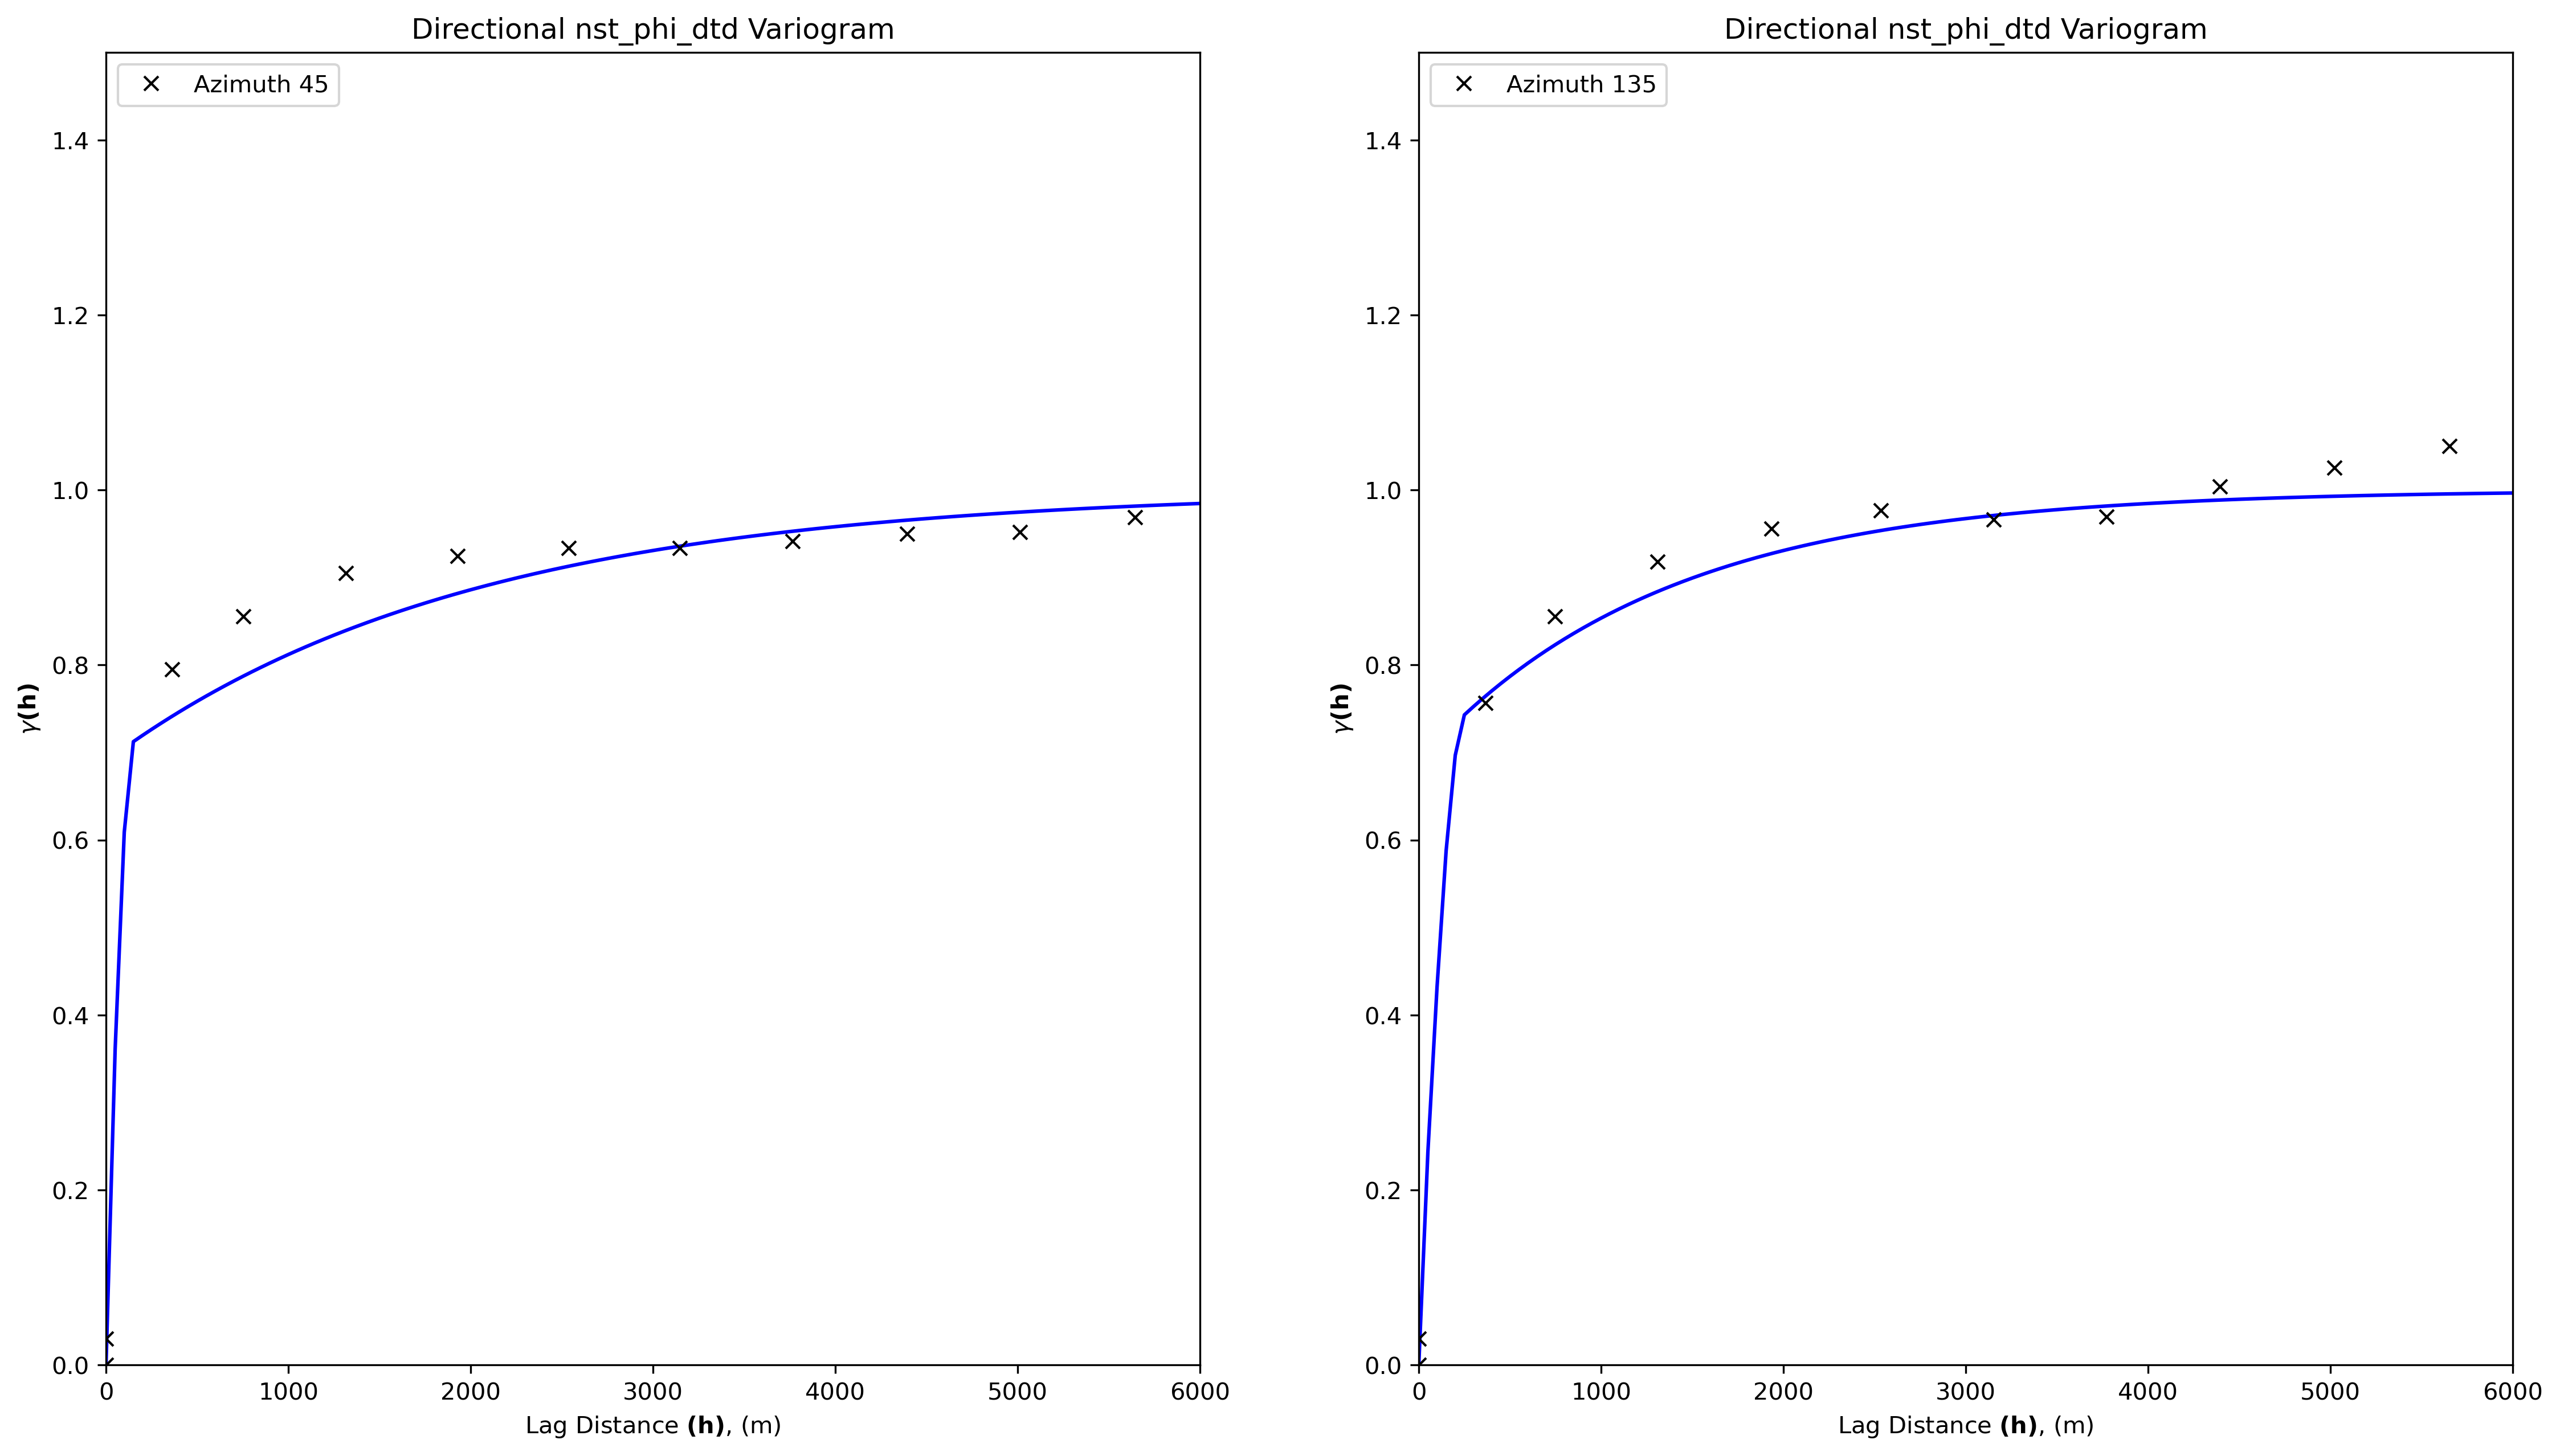

In [16]:

#%% ANISTOROPIC VARIOGRAM FITTING
nug = 0.04; nst = 2                                             # 2 nest structure variogram model parameters
it1 = 1; cc1 = 0.65; azi1 = 135; hmaj1 = 250; hmin1 = 150
it2 = 2; cc2 = 0.31; azi2 = 45; hmaj2 = 6000; hmin2 = 4000

vario_phi = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2) # make model object )#
xlag = 100/2; nlag = 120; 
azm = 45;                                # project the model in the 045 azimuth
index45,h45,gam45,cov45,ro45 = geostats.vmodel(nlag,xlag,azm,vario_phi)
azm = 135                                                      # project the model in the 135 azimuth
index135,h135,gam135,cov135,ro135 = geostats.vmodel(nlag,xlag,azm,vario_phi)

plt.figure(dpi=300)
plt.subplot(1,2,1)
# plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h45,gam45,color = 'blue')
plt.plot(lag_phi[0,:],gamma_phi[0,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[0]))
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional nst_phi_dtd Variogram')
plt.xlim([0,xlag*nlag])
plt.ylim([0,1.5])
plt.legend(loc='upper left')

plt.subplot(1,2,2)
# plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h135,gam135,color = 'blue')
plt.plot(lag_phi[1,:],gamma_phi[1,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[1]))
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional nst_phi_dtd Variogram')
plt.xlim([0,xlag*nlag])
plt.ylim([0,1.5])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

## Kriging and SGS

In [17]:
#%% KRIGING
xmn = dx/2 # xmin+
xsiz = dx
ymn = dy/2 #
ysiz = dy
cmap = plt.cm.inferno 

# SGS common parameters
nxdis = nydis = 1
ndmin = 0; ndmax = 16; radius = 8000; 
tmin = -9999; tmax = 9999; lmin=-3; lmax=3

# df_2D_prop['empty']=np.nan

skmean_theta = np.mean(df_2D_prop['nst_theta_dtd'].values)

nstnt_theta_kmap, nstnt_theta_vmap = geostats.kb2d(df_2D_prop,'Easting','Northing','nst_theta_dtd',
    tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis=nxdis,nydis=nydis,
    ndmin=ndmin,ndmax=ndmax,radius=radius,ktype=0,skmean=skmean_theta,vario=vario_theta)

# SGS sim
# see param description at http://www.gslib.com/gslib_help/sgsim.html
sim_nstnt_theta = geostats.sgsim(df_2D_prop,'Easting','Northing','nst_theta_dtd',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=0,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=lmin,zmax=lmax,ltail=1,ltpar=lmin,utail=1,utpar=lmax,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=12345,
            ndmin=ndmin,ndmax=ndmax,nodmax=ndmax,mults=0,nmult=2,noct=-1,#radius=radius,radius1=1,sang1=0,
            #mxctx=10,mxcty=10,
                                 ktype=0,colocorr=0.0,sec_map=0,vario=vario_theta)

skmean_phi = np.mean(df_2D_prop['nst_phi_dtd'].values)

nstnt_phi_kmap, nstnt_phi_vmap = geostats.kb2d(df_2D_prop,'Easting','Northing','nst_phi_dtd',
    tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis=nxdis,nydis=nydis,
    ndmin=ndmin,ndmax=ndmax,radius=radius,ktype=0,skmean=skmean_phi,vario=vario_phi)

# SGS sim
# see param description at http://www.gslib.com/gslib_help/sgsim.html
sim_nstnt_phi = geostats.sgsim(df_2D_prop,'Easting','Northing','nst_phi_dtd',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=0,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=lmin,zmax=lmax,ltail=1,ltpar=lmin,utail=1,utpar=lmax,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=12346,
            ndmin=ndmin,ndmax=ndmax,nodmax=ndmax,mults=0,nmult=2,noct=-1,#radius=radius,radius1=1,sang1=0,
            #mxctx=10,mxcty=10,
                               ktype=0,colocorr=0.0,sec_map=0,vario=vario_phi)


100%|███████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 162.73it/s]


  Estimated   22400 blocks 
      average   0.00012934075844826614  variance  2.892218477354199e-13

 Data for SGSIM: Number of acceptable data     = 4843
                 Number trimmed                = 0
                 Weighted Average              = 0.0001
                 Weighted Variance             = 0.9989
                 Weighted Transformed Average  = 0.0001
                 Weighted Transformed Variance = 0.9989
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 2240
   currently on node 4480
   currently on node 6720
   currently on node 8960
   currently on node 11200
   currently on node 13440
   currently on node 15680
   currently on node 17920
   currently on node 20160
Reassigning data to nodes

 Realization 0: number   = 22400
                                   mean     = 0.0091 (close to 0.0?)
                                   variance = 0.9997 (close to gammabar(V,V)? approx. 1.0)


100%|███████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 160.93it/s]


  Estimated   22400 blocks 
      average   9.697387003187022e-05  variance  8.363172404426702e-13

 Data for SGSIM: Number of acceptable data     = 4843
                 Number trimmed                = 0
                 Weighted Average              = 0.0001
                 Weighted Variance             = 0.9992
                 Weighted Transformed Average  = 0.0001
                 Weighted Transformed Variance = 0.9992
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 2240
   currently on node 4480
   currently on node 6720
   currently on node 8960
   currently on node 11200
   currently on node 13440
   currently on node 15680
   currently on node 17920
   currently on node 20160
Reassigning data to nodes

 Realization 0: number   = 22400
                                   mean     = 0.0424 (close to 0.0?)
                                   variance = 1.0238 (close to gammabar(V,V)? approx. 1.0)


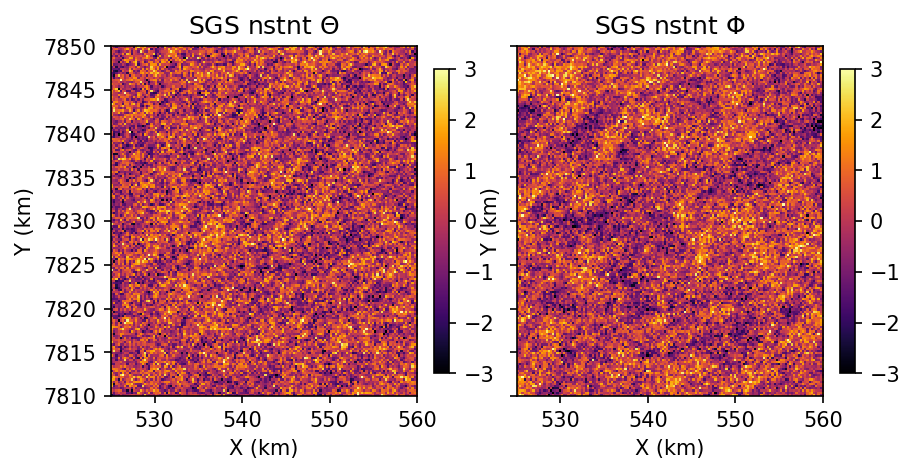

In [18]:
sim_nstnt_theta = np.squeeze(sim_nstnt_theta,axis=0)
sim_nstnt_phi = np.squeeze(sim_nstnt_phi,axis=0)

myextent = np.array([xmin,xmax,ymin,ymax])/1E3
fig,ax = plt.subplots(1,2,dpi=150,sharey=True)
im0 = ax[0].imshow(sim_nstnt_theta, cmap='inferno', vmin=-3, vmax=3, extent = myextent, interpolation='none')
ax[0].set_title('SGS nstnt $\Theta$')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
fig.colorbar(im0,ax=ax[0],orientation='vertical', fraction=.045)

im1 = ax[1].imshow(sim_nstnt_phi, cmap='inferno', vmin=-3, vmax=3, extent = myextent, interpolation='none')
ax[1].set_title('SGS nstnt $\Phi$')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')
fig.colorbar(im1,ax=ax[1],orientation='vertical', fraction=.045)
plt.show()

In [19]:
# Back transform
sim_theta_back = np.interp(sim_nstnt_theta,df_2D_prop.loc[:,'tns_theta_dtd'],df_2D_prop.loc[:,'tv_theta_dtd']) + trend_theta
sim_phi_back = np.interp(sim_nstnt_phi,df_2D_prop.loc[:,'tns_phi_dtd'],df_2D_prop.loc[:,'tv_phi_dtd']) + trend_theta

theta_phi_min = 0.0
theta_phi_max = np.pi/2
sim_theta_back[sim_theta_back<theta_phi_min]=theta_phi_min
sim_phi_back[sim_phi_back<theta_phi_min]=theta_phi_min
sim_theta_back[sim_theta_back>theta_phi_max]=theta_phi_max
sim_phi_back[sim_phi_back>theta_phi_max]=theta_phi_max


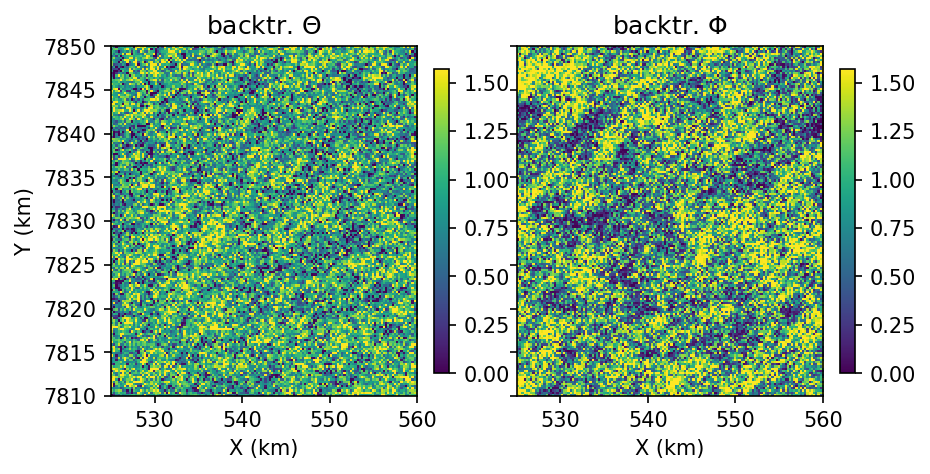

In [20]:
fig,ax = plt.subplots(1,2,dpi=150,sharey=True)
im0 = ax[0].imshow(sim_theta_back, cmap='viridis', extent = myextent, interpolation='none')
ax[0].set_title('backtr. $\Theta$')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
fig.colorbar(im0,ax=ax[0],orientation='vertical', fraction=.045)

im1 = ax[1].imshow(sim_phi_back, cmap='viridis', extent = myextent, interpolation='none')
ax[1].set_title('backtr. $\Phi$')
ax[1].set_xlabel('X (km)')
fig.colorbar(im1,ax=ax[1],orientation='vertical', fraction=.045)
plt.show()

In [21]:
# SIMULATED PROPORTIONS!
p1_clay,p2_sand,p3_inte = get_proportions_from_spherical_coordinates(sim_theta_back,sim_phi_back)

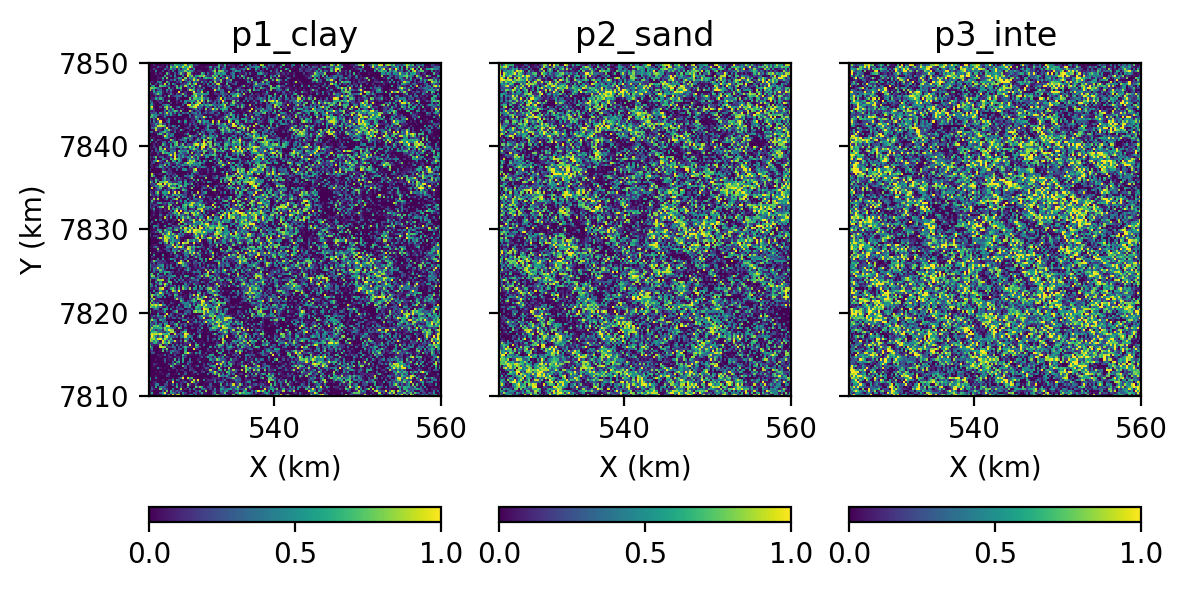

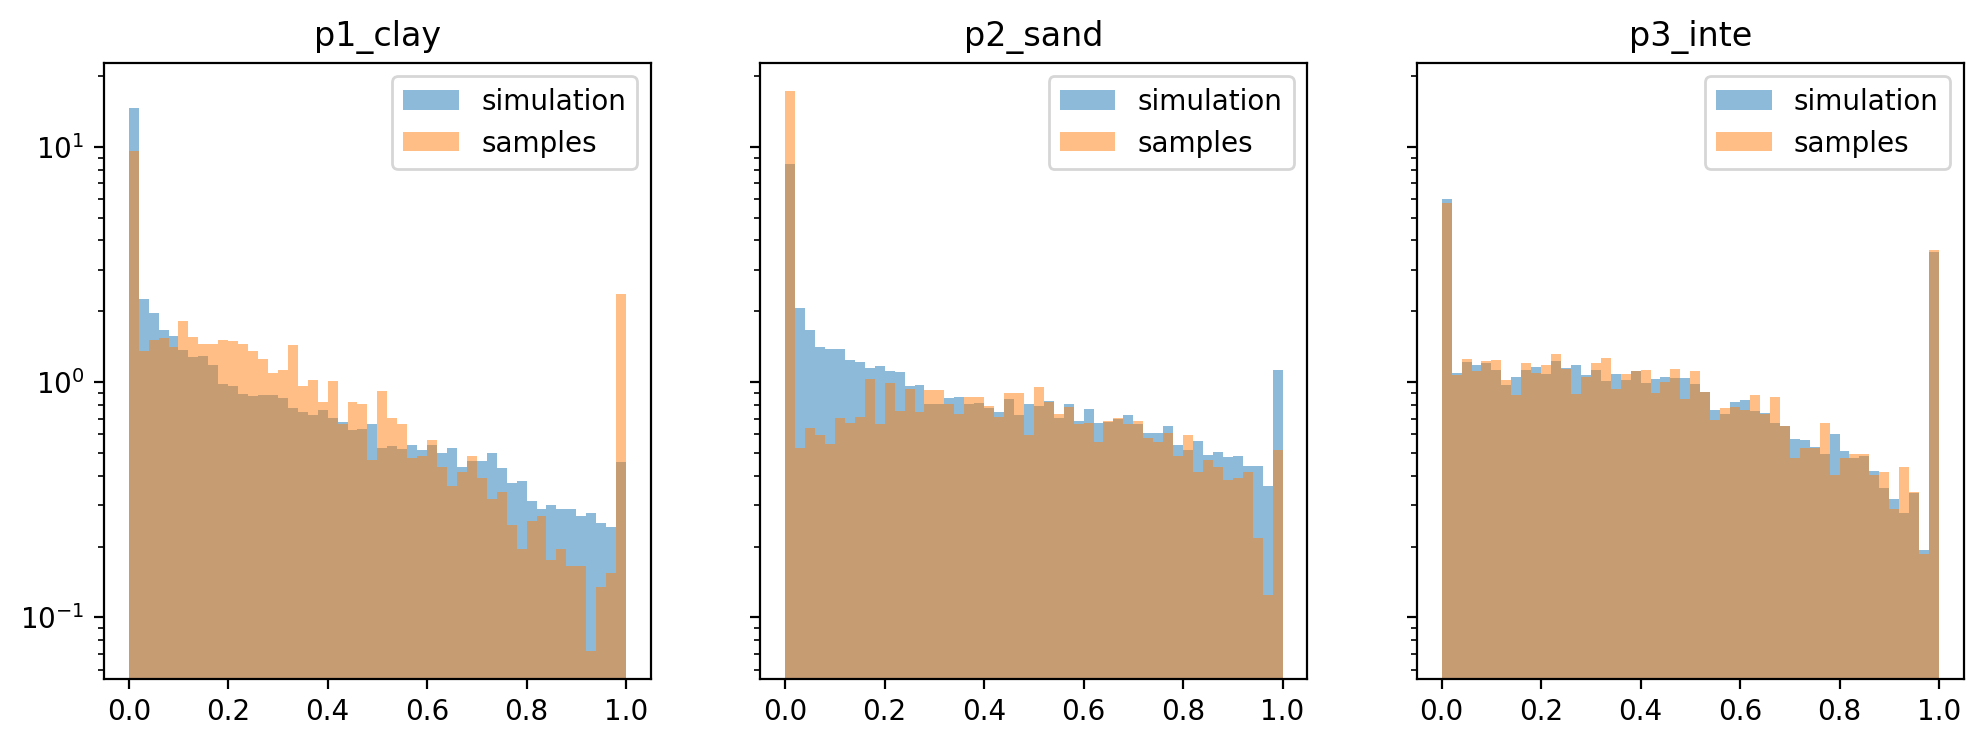

In [22]:
nbins=50

fig,ax = plt.subplots(1,3,dpi=200,sharey=True)
ax[0].set_title('p1_clay')
im0=ax[0].imshow(p1_clay, origin='lower', cmap='viridis', extent = myextent, interpolation='none')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('p2_sand')
im1=ax[1].imshow(p2_sand, origin='lower', cmap='viridis', extent = myextent, interpolation='none')
ax[1].set_xlabel('X (km)')
fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

ax[2].set_title('p3_inte')
im2=ax[2].imshow(p3_inte, origin='lower', cmap='viridis', extent = myextent, interpolation='none')
ax[2].set_xlabel('X (km)')
fig.colorbar(im2,ax=ax[2],orientation='horizontal', fraction=.035)
plt.show()

fig,ax = plt.subplots(1,3,dpi=200,sharey=True,figsize=(12,4))
ax[0].set_title('p1_clay')
ax[0].hist(p1_clay.flatten(),nbins,density=True,alpha=0.5)
ax[0].hist(df_2D_prop['prop_clay'].values,nbins,density=True,alpha=0.5)
ax[0].set_yscale('log')
ax[0].legend(['simulation','samples'])

ax[1].set_title('p2_sand')
ax[1].hist(p2_sand.flatten(),nbins,density=True,alpha=0.5)
ax[1].hist(df_2D_prop['prop_sand'].values,nbins,density=True,alpha=0.5)
ax[1].legend(['simulation','samples'])

ax[2].set_title('p3_inte')
ax[2].hist(p3_inte.flatten(),nbins,density=True,alpha=0.5)
ax[2].hist(df_2D_prop['prop_inte'].values,nbins,density=True,alpha=0.5)
ax[2].legend(['simulation','samples'])

plt.show()